# BIBLIOTECAS

In [112]:
# !pip install lifelines

In [113]:
import lifelines as lf # possui os métodos de estudo de sobrevivencia
from lifelines.statistics import multivariate_logrank_test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LEITURA ARQUIVO EQUIPAMENTOS

In [114]:
# arquivo contendo os dados mensurados de falha dos equipamentos

arquivo = pd.read_csv( 'comparacao.csv', sep= ';')

In [115]:
arquivo.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO
0,05/10/2011,14/11/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
1,11/04/2011,05/08/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
2,28/04/2016,30/07/2020,UB,2002,NAO FALHOU,ELETROMECANICO,A
3,26/04/2012,27/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A
4,23/04/2012,13/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A


- `DATA-INSTALACAO`: data em que o equipamento foi instalado
- `DATA-RETIRADA`: data em que o equipamento foi retirado
- `AREA-LOCAL`: local em que o equipamento estava instalado (URBANO ou RURAL)
- `ANO-FAB`: ano em que o equipamento foi fabricado
- `FALHOU?`: equipamento falhou ou não.
- `TECNOLOGIA`: tipo do equipamento. ELETRONICO ou ELETROMECANICO
- `MODELO`: modelo ficticio do equipamento

# TRANSFORMAÇÃO

### Transformação do dataframe

- corrigir Datas e a VIDA-UTIL do equipamento

In [116]:
# Verificar se há algum item faltante

arquivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65386 entries, 0 to 65385
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DATA-INSTALACAO  65386 non-null  object
 1   DATA-RETIRADA    65386 non-null  object
 2   AREA-LOCAL       65386 non-null  object
 3   ANO-FAB          65386 non-null  int64 
 4   FALHOU?          65386 non-null  object
 5   TECNOLOGIA       65386 non-null  object
 6   MODELO           65386 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB


In [117]:
# obter quantos dias o equipamento permaneceu em operação

arquivo['DATA-RETIRADA'] = pd.to_datetime(arquivo['DATA-RETIRADA'])
arquivo['DATA-INSTALACAO'] = pd.to_datetime(arquivo['DATA-INSTALACAO'])

arquivo['VIDA-UTIL'] = (arquivo['DATA-RETIRADA']-arquivo['DATA-INSTALACAO'])/np.timedelta64(1,'D')

arquivo['VIDA-UTIL'] = arquivo['VIDA-UTIL']/365

In [118]:
# transformar os dados da coluna FALHOU? em numérico
# FALHA (FALHOU) = 1 / CENSURA (NAO FALHOU) = 0

arquivo['FALHOU?2'] = 1
arquivo.loc[arquivo['FALHOU?'] == 'NAO FALHOU', 'FALHOU?2'] = 0

### Teste LogRank

- serve para determinar quais variaveis são relevantes para o modelo através do `p-valor`

In [119]:
# usando metade dos dados como amostra

teste_log_rank = arquivo.sample(int(arquivo.shape[0]/2),random_state=1)
teste_log_rank.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2
22568,2012-02-13,2017-09-29,RR,2012,NAO FALHOU,ELETROMECANICO,A,5.630137,0
24489,2010-06-05,2017-05-30,UB,2010,NAO FALHOU,ELETROMECANICO,A,6.989041,0
10409,2015-07-23,2020-05-11,UB,2009,FALHOU,ELETROMECANICO,A,4.805479,1
20799,2011-08-08,2018-12-22,UB,2010,NAO FALHOU,ELETROMECANICO,A,7.378082,0
56682,2009-02-03,2017-10-17,UB,2003,NAO FALHOU,ELETROMECANICO,C,8.706849,0


In [120]:
itens = ['AREA-LOCAL','TECNOLOGIA','MODELO','ANO-FAB']

# verificar quais valores sao relevantes através do p-valor

for i in itens:
    print("TESTE LOGRANK PARA A COVARIAVEL:\n",i)
    result= multivariate_logrank_test(teste_log_rank['VIDA-UTIL'], teste_log_rank[i], teste_log_rank['FALHOU?2'])
    print(result.print_summary())
    print('\n')

TESTE LOGRANK PARA A COVARIAVEL:
 AREA-LOCAL


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.76 0.38      1.38

None


TESTE LOGRANK PARA A COVARIAVEL:
 TECNOLOGIA


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        1481.38 <0.005       inf

None


TESTE LOGRANK PARA A COVARIAVEL:
 MODELO


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        3797.89 <0.005       inf

None


TESTE LOGRANK PARA A COVARIAVEL:
 ANO-FAB


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 17
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
       15200.44 <0.005       inf

None




In [121]:
# Remover o item que ficou com p-valor > 0.05 - variavel nao é relevante

itens.remove('AREA-LOCAL')
itens

['TECNOLOGIA', 'MODELO', 'ANO-FAB']

### Modelo Referência

- Os métodos paramétricos/semi parametricos necessitam de um grupo de referência para a regressão. 
- Geralmente, nesses casos, buscamos identificar o item que mais dura em operação como 'baseline'

In [122]:
arquivo['Chave'] = arquivo['MODELO'] + '-' + arquivo['TECNOLOGIA'] + '-' + arquivo['ANO-FAB'].astype(str)
arquivo.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2,Chave
0,2011-05-10,2020-11-14,UB,2011,NAO FALHOU,ELETROMECANICO,A,9.523288,0,A-ELETROMECANICO-2011
1,2011-11-04,2020-05-08,UB,2011,NAO FALHOU,ELETROMECANICO,A,8.515068,0,A-ELETROMECANICO-2011
2,2016-04-28,2020-07-30,UB,2002,NAO FALHOU,ELETROMECANICO,A,4.257534,0,A-ELETROMECANICO-2002
3,2012-04-26,2020-07-27,UB,2012,NAO FALHOU,ELETROMECANICO,A,8.257534,0,A-ELETROMECANICO-2012
4,2012-04-23,2020-07-13,UB,2012,NAO FALHOU,ELETROMECANICO,A,8.227397,0,A-ELETROMECANICO-2012


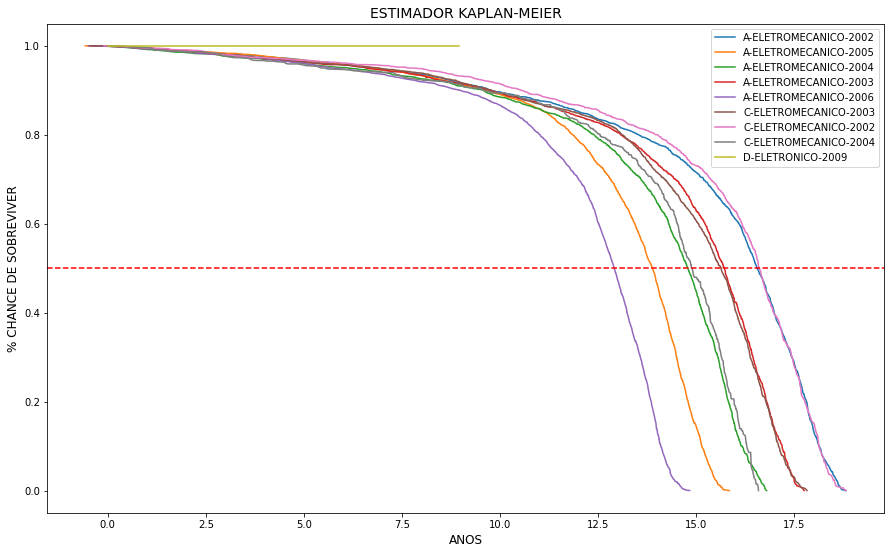

In [123]:
fig, axes = plt.subplots(1, 1, figsize=(15,9))
km_fitter = lf.KaplanMeierFitter()
for i in arquivo['Chave'].unique():
    tempo = arquivo['VIDA-UTIL'].loc[arquivo['Chave'] == i]
    evento = arquivo['FALHOU?2'].loc[arquivo['Chave'] == i]
    
    km_fitter.fit(tempo, event_observed = evento, label = i)
    if km_fitter.median_survival_time_ > 12:
        km_fitter.survival_function_.plot(ax = axes)
        axes.set_title('ESTIMADOR KAPLAN-MEIER',fontsize = 14)
        axes.set_xlabel('ANOS', fontsize = 12)
        axes.set_ylabel('% CHANCE DE SOBREVIVER', fontsize = 12)
axes.axhline(0.5, color = 'red', linestyle = '--')
plt.show()

##### Referencia será o equipamento C, ELETROMECANICO de 2002

In [124]:
referencia = pd.DataFrame([['MODELO','C'],['TECNOLOGIA','ELETROMECANICO'],['ANO-FAB',2002]],
                          columns = ['CLASSE','ITEM'])
referencia

,CLASSE,ITEM
0,MODELO,C
1,TECNOLOGIA,ELETROMECANICO
2,ANO-FAB,2002


### Criação das variaveis "dummies"

- necessário transformar em numérico para a regressão
- semelhante ao tratamento do OneHotEncoder()

In [125]:
dummies = arquivo.copy()

for i,item in enumerate(referencia['CLASSE'].unique()):
    dummies[item].loc[dummies[item] == referencia['ITEM'][i]] = 0

dummies.sort_values(by=['MODELO','ANO-FAB','TECNOLOGIA'],ascending=[True,True,True], inplace=True)
dummies.head()

C:\Users\pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2,Chave
51769,2002-04-24,2020-03-09,UB,0,FALHOU,0,0,17.887671,1,C-ELETROMECANICO-2002
51771,2003-07-06,2019-11-04,UB,0,FALHOU,0,0,16.342466,1,C-ELETROMECANICO-2002
51777,2002-11-29,2019-05-29,UB,0,NAO FALHOU,0,0,16.506849,0,C-ELETROMECANICO-2002
51778,2004-01-21,2020-03-08,UB,0,FALHOU,0,0,16.139726,1,C-ELETROMECANICO-2002
51779,2018-04-30,2018-05-28,UB,0,FALHOU,0,0,0.076712,1,C-ELETROMECANICO-2002


In [126]:
# colunas desnecessárias
dummies.drop(['FALHOU?','Chave','DATA-INSTALACAO','DATA-RETIRADA','AREA-LOCAL'],axis=1,inplace=True)

#"dummificação"
dummies = pd.get_dummies(dummies,columns = ['MODELO','ANO-FAB','TECNOLOGIA'],drop_first = True)

dummies.head()

,VIDA-UTIL,FALHOU?2,MODELO_A,MODELO_B,MODELO_D,ANO-FAB_2003,ANO-FAB_2004,ANO-FAB_2005,ANO-FAB_2006,ANO-FAB_2007,...,ANO-FAB_2011,ANO-FAB_2012,ANO-FAB_2013,ANO-FAB_2014,ANO-FAB_2015,ANO-FAB_2016,ANO-FAB_2017,ANO-FAB_2018,ANO-FAB_2019,TECNOLOGIA_ELETRONICO
51769,17.887671,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51771,16.342466,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51777,16.506849,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51778,16.139726,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51779,0.076712,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modelo de Cox

- Aqui será feito o 'fit' do modelo;
- Com os dados do print_summary(), remove-se os itens com p-valor > 0.05 e realiza novamente o fit;
- Após o fit definitivo, obtem-se os parametros que melhor se encaixam no modelo

In [127]:
# coloca-se um penalizer <0.1 quando há erro de convergência devido ao tamanho do passo do otimizador

cox_model = lf.CoxPHFitter(penalizer=0.05)

In [128]:
cox_model.fit(dummies, duration_col='VIDA-UTIL', event_col='FALHOU?2')

<lifelines.CoxPHFitter: fitted with 65386 total observations, 35091 right-censored observations>

In [129]:
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 65386 total observations, 35091 right-censored observations>
             duration col = 'VIDA-UTIL'
                event col = 'FALHOU?2'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 65386
number of events observed = 30295
   partial log-likelihood = -289869.05
         time fit was run = 2021-05-23 19:54:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
MODELO_A                0.34       1.41       0.02             0.31             0.37                 1.36                 1.45
MODELO_B               -0.42       0.66       0.05            -0.51            -0.33                 0.60                 0.72
MODELO_D                1.12       3.08       0.04             1.04             1.21                 2.83                 3.35
ANO-FAB_2003           -0.26       0.77       0.02            -0.30            -0.22                 0.74                 0.80
ANO-FAB_2004           -0.05       0.95       0.02            -0.09            -0.00                 0.91                 1.00
ANO-FAB_2005            0.20       1.22       0.02             0.15             0.24                 1.17                 1.28
ANO-FAB_2006            0.53       1.70       0.02             0.49             0.57                 1.63                 1.78
ANO-FAB_2007            0.89       2.42       0.02             0.84             0.93                 2.32                 2.53
ANO-FAB_2008            1.21       3.35       0.02             1.17             1.25                 3.21                 3.50
ANO-FAB_2009            1.52       4.57       0.03             1.46             1.58                 4.32                 4.84
ANO-FAB_2010            1.83       6.21       0.03             1.77             1.88                 5.90                 6.53
ANO-FAB_2011            2.19       8.93       0.03             2.14             2.24                 8.48                 9.40
ANO-FAB_2012            2.17       8.72       0.04             2.09             2.24                 8.07                 9.41
ANO-FAB_2013            2.77      16.04       0.07             2.63             2.92                13.89                18.52
ANO-FAB_2014            1.27       3.56       0.07             1.13             1.41                 3.09                 4.10
ANO-FAB_2015            1.29       3.65       0.05             1.20             1.39                 3.31                 4.02
ANO-FAB_2016            1.30       3.68       0.08             1.14             1.46                 3.13                 4.32
ANO-FAB_2017            2.54      12.69       0.68             1.20             3.88                 3.33                48.33
ANO-FAB_2018            2.54      12.64       0.87             0.82             4.25                 2.28                70.21
ANO-FAB_2019            4.04      56.57       0.55             2.96             5.11                19.24               166.31
TECNOLOGIA_ELETRONICO   0.66       1.93       0.04             0.59             0.73                 1.80                 2.08

                           z      p   -log2(p)
covariate                                     
MODELO_A               19.74 <0.005     285.67
MODELO_B               -9.31 <0.005      66.12
MODELO_D               26.29 <0.005     503.43
ANO-FAB_2003          -12.45 <0.005     115.75
ANO-FAB_2004           -1.97   0.05       4.35
ANO-FAB_2005            8.76 <0.005      58.83
ANO-FAB_2006           23.92 <0.005     417.50
ANO-FAB_2007           39.75 <0.005        inf
ANO-FAB_2008           54.75 <0.005        inf
ANO-FAB_2009           52.31 <0.005        inf
ANO-FAB_2010           70.41 <0.005        inf
ANO-FAB_2011           84.

In [130]:
# parametros relevantes do Cox (coluna indice com as colunas das 'dummies' que melhor encaixam no modelo)

parametros = cox_model.hazard_ratios_.index
parametros

Index(['MODELO_A', 'MODELO_B', 'MODELO_D', 'ANO-FAB_2003', 'ANO-FAB_2004',
       'ANO-FAB_2005', 'ANO-FAB_2006', 'ANO-FAB_2007', 'ANO-FAB_2008',
       'ANO-FAB_2009', 'ANO-FAB_2010', 'ANO-FAB_2011', 'ANO-FAB_2012',
       'ANO-FAB_2013', 'ANO-FAB_2014', 'ANO-FAB_2015', 'ANO-FAB_2016',
       'ANO-FAB_2017', 'ANO-FAB_2018', 'ANO-FAB_2019',
       'TECNOLOGIA_ELETRONICO'],
      dtype='object', name='covariate')

# Predição Cox

- para a predição, os valores devem estar filtrados pelos parâmetros que o Cox entregou;
- Além disso, o dataframe deve estar no formato de "dummies", como repassamos anteriormente

In [131]:
# amostra aleatoria de 10 itens

teste = dummies.sample(10)
teste = teste[parametros]

# predição
cox_model.predict_expectation(teste.to_numpy())

0     9.400609
1    14.437583
2    13.961572
3    13.166729
4    13.961572
5    15.344720
6    12.325857
7     6.362444
8    12.325857
9     8.227493
dtype: float64

In [132]:
cox_model.predict_survival_function(teste.to_numpy())

,0,1,2,3,4,5,6,7,8,9
-0.873973,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
-0.827397,9.999735e-01,0.999997,0.999996,9.999950e-01,0.999996,0.999998,9.999928e-01,9.998908e-01,9.999928e-01,9.999543e-01
-0.797260,9.999735e-01,0.999997,0.999996,9.999950e-01,0.999996,0.999998,9.999928e-01,9.998908e-01,9.999928e-01,9.999543e-01
-0.789041,9.999735e-01,0.999997,0.999996,9.999950e-01,0.999996,0.999998,9.999928e-01,9.998908e-01,9.999928e-01,9.999543e-01
-0.769863,9.999735e-01,0.999997,0.999996,9.999950e-01,0.999996,0.999998,9.999928e-01,9.998908e-01,9.999928e-01,9.999543e-01
...,...,...,...,...,...,...,...,...,...,...
18.715068,3.905650e-30,0.000509,0.000096,2.513453e-06,0.000096,0.005809,1.037963e-08,3.703343e-122,1.037963e-08,1.538111e-51
18.756164,3.905650e-30,0.000509,0.000096,2.513453e-06,0.000096,0.005809,1.037963e-08,3.703343e-122,1.037963e-08,1.538111e-51
18.769863,9.801044e-32,0.000337,0.000058,1.246033e-06,0.000058,0.004389,3.816776e-09,9.124527e-129,3.816776e-09,2.640629e-54
18.813699,5.315635e-34,0.000188,0.000028,4.614313e-07,0.000028,0.002952,9.259678e-10,4.024546e-138,9.259678e-10,3.212906e-58


In [133]:
# Curva ROC
cox_model.concordance_index_

0.7515794626123086

In [134]:
# para mais detalhes, consulte:
# https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html